#Introduction

Home Credit B.V. is an international non-bank financial institution founded in 1997 in the Czech Republic and headquartered in Netherlands. The company operates in 9 countries and focuses on installment lending primarily to people with little or no credit history. 

In this project, we're tasked with trying to predict if some certain users will default on the payment of their loans given information across several datasets. This notebook is heavily inspired by earlier work done by [here](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook#Conclusions) with some new ideas. 


## Data Description

* application_{train|test}.csv:
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET). Static data for all applications. One row represents one loan in our data sample.

* bureau.csv:
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

* bureau_balance.csv:
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

* POS_CASH_balance.csv:
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

* credit_card_balance.csv:
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

* previous_application.csv:
All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

* installments_payments.csv:
Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

* HomeCredit_columns_description.csv:
This file contains descriptions for the columns in the various data files.

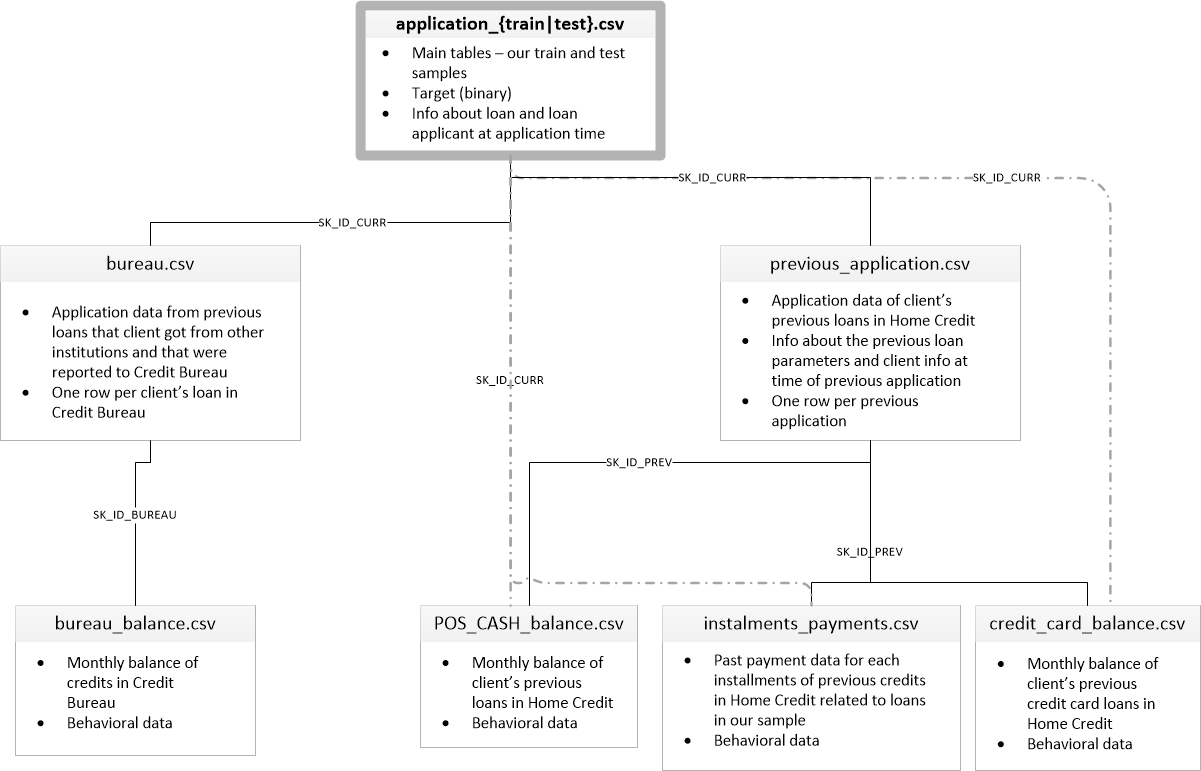

## Metric Used

The metric used for evaluation in this competition is the Area under Receiving operating characteristic (AUC ROC) between the predicted probability and the observed target

# Preparing the Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
! pip install kaggle 
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c home-credit-default-risk

100% 685M/688M [00:05<00:00, 121MB/s] 
100% 688M/688M [00:05<00:00, 132MB/s]


In [4]:
! unzip /content/home-credit-default-risk.zip -d /content/input

Archive:  /content/home-credit-default-risk.zip
  inflating: /content/input/HomeCredit_columns_description.csv  
  inflating: /content/input/POS_CASH_balance.csv  
  inflating: /content/input/application_test.csv  
  inflating: /content/input/application_train.csv  
  inflating: /content/input/bureau.csv  
  inflating: /content/input/bureau_balance.csv  
  inflating: /content/input/credit_card_balance.csv  
  inflating: /content/input/installments_payments.csv  
  inflating: /content/input/previous_application.csv  
  inflating: /content/input/sample_submission.csv  


# Loading the Dataset

In [5]:
app_train = pd.read_csv('/content/input/application_train.csv')
app_test = pd.read_csv('/content/input/application_test.csv')

len(app_train), len(app_test)

(307511, 48744)

In [6]:
app_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis

In [10]:
# define some utility functions
def missing_values_table(df):
    """Returns a dataframe of number of missing entries per column in df"""
    miss_val = df.isnull().sum()
    miss_val_percent = (100 * df.isnull().sum())/len(df)
    miss_val_table = pd.concat([miss_val, miss_val_percent], axis=1)
    miss_val_table = miss_val_table.rename(columns={0:'Missing Values', 1:'% of Total Values'})
    
    # sort the table by missing
    miss_val_table = miss_val_table[miss_val_table.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    
    # print some summary information
    print(f'The dataframe has {str(df.shape[1])} columns.\nThere are {str(miss_val_table.shape[0])} columns with missing values')
    return miss_val_table


def quality_report(df):
    """Returns the quality of data in terms of missing entries, duplicates and data types"""
    dtype = df.dtypes
    nuniq = df.T.apply(lambda x: x.nunique(), axis=1)
    total_null = df.isnull().sum().sort_values(ascending=False)
    percent_null = (df.isnull().sum()/len(df) * 100).sort_values(ascending=False)
    
    quality_df = pd.concat([total_null, percent_null, nuniq, dtype], axis=1, keys=['Total_Null', 'Percent_Null', 
                                                                                 'N_Unique', 'Datatype'])
    return quality_df

def categorical_feature_plot(df):
    """Plots a countplot for all categorical features present in the dataframe"""
    cat_features = df.select_dtypes(include='object').columns
    for feature in cat_features:
        plt.figure(figsize=(12,5))
        sns.countplot(x = feature, data=df)
        plt.tight_layout()
    plt.show()

def numeric_distribution_plot(df):
    """Plots a displot for all numeric features present in the dataframe"""
    num_features = df.select_dtypes(exclude='object').columns # int and float are included
    for feature in num_features:
        plt.figure(figsize=(12, 5))
        sns.displot(data=df, x= feature)
    plt.show()

#### TARGET

In [7]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

From this, we can tell that the dataset is very imbalanced with the target 0 having up to 10x more data observations than the target 1. 

Looking into the data description. Target = 0 means that there was NO difficulty in repaying the loan. Target = 1 means issues in repaying. We can visualize this info using matplotlib's hist


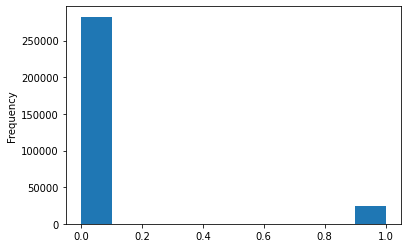

In [8]:
app_train['TARGET'].astype(int).plot.hist()

We can also visualize this in Seaborn by using the countplot function

#### Missing Entries

In [11]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

The dataframe has 122 columns.
There are 67 columns with missing values


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [12]:
# similar info is presented by
report = quality_report(app_train)
report.head(20)

,Total_Null,Percent_Null,N_Unique,Datatype
COMMONAREA_MEDI,214865,69.872297,3202,float64
COMMONAREA_AVG,214865,69.872297,3181,float64
COMMONAREA_MODE,214865,69.872297,3128,float64
NONLIVINGAPARTMENTS_MODE,213514,69.432963,167,float64
NONLIVINGAPARTMENTS_AVG,213514,69.432963,386,float64
NONLIVINGAPARTMENTS_MEDI,213514,69.432963,214,float64
FONDKAPREMONT_MODE,210295,68.386172,4,object
LIVINGAPARTMENTS_MODE,210199,68.354953,736,float64
LIVINGAPARTMENTS_AVG,210199,68.354953,1868,float64
LIVINGAPARTMENTS_MEDI,210199,68.354953,1097,float64


Since we have a lot of Categorical features in the dataset, we should encode them. The approach taken in this notebook is to use Scikit-Learn's LabelEncoder for the Categorical features that have just under 3 unique values and to OneHotEncode the other features that have many different values

#### Encoding Categorical Features

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()

le_count = 0 # this keeps a count of labels encoded

for col in app_train:
    if app_train[col].dtype == 'object':
        # if 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2: # fit on the column
            label_encoder.fit(app_train[col])
            app_train[col] = label_encoder.transform(app_train[col])
            app_test[col] = label_encoder.transform(app_test[col])
            
            le_count += 1
            
print(f'{le_count} columns have been label encoded')

3 columns have been label encoded


In [14]:
# one hot encoding of features
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

app_train.shape, app_test.shape

((307511, 243), (48744, 239))

In [15]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0


We need to align the dataset since we see more columns in the Train dataset than the test dataset. This is as a result of some categorical values present in the Train not being present in the test dataset. Since our Sci-kit learn transformers and models need to see the test and train with the same number of columns, we need to align both dataframes. We do this with pandas df.align method

Documentation for pandas.DataFrame align here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.align.html

In [16]:
train_labels = app_train['TARGET'] # this is the labels we need

# let's align
app_train, app_test = app_train.align(app_test, join='inner', axis=1) # uses only the columns present in both dataframes

app_train['TARGET'] = train_labels # add the target back to the train df
app_train.shape, app_test.shape

((307511, 240), (48744, 239))

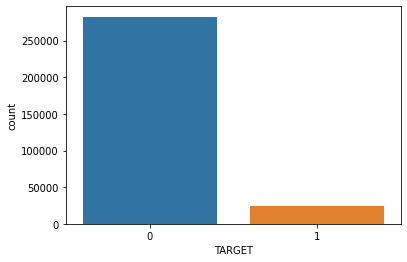

In [9]:
# another way to visualize
sns.countplot(x='TARGET', data=app_train)

#### DAYS_BIRTH and DAYS_EMPLOYED

In [17]:
(app_train['DAYS_BIRTH']/-365).describe() # the Age relative to the time dataset was created

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [18]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 0, 'Days Employment')

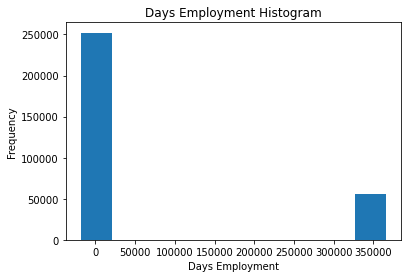

In [19]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

We have an outlier there

In [20]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]

# let's see if these have any effect on the target we need to predict

print(f"The anomalies default on {round(anom['TARGET'].mean() * 100, 2)}% of loans")
print(f"The Non-anomalies default on {round(non_anom['TARGET'].mean() * 100, 2)}% of loans")
print(f'There are {len(anom)} rows with anomalous days of employment')

The anomalies default on 5.4% of loans
The Non-anomalies default on 8.66% of loans
There are 55374 rows with anomalous days of employment


In [21]:
# create an anomalous flag
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] == 365243
app_test['DAYS_EMPLOYED_ANOM'] = app_test['DAYS_EMPLOYED'] == 365243

# replace the anomalies with not a number
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

# let's see how many anomalous rows are there in the test dataset
print(f"There are {app_test['DAYS_EMPLOYED_ANOM'].sum()} rows with anomalies out of {len(app_test)} rows")

There are 9274 rows with anomalies out of 48744 rows


#### Correlation and some plots

In [22]:
corr_matrix = app_train.corr()
corr_matrix['TARGET']

SK_ID_CURR                  -0.002108
NAME_CONTRACT_TYPE          -0.030896
FLAG_OWN_CAR                -0.021851
FLAG_OWN_REALTY             -0.006148
CNT_CHILDREN                 0.019187
                               ...   
WALLSMATERIAL_MODE_Wooden    0.007946
EMERGENCYSTATE_MODE_No      -0.042201
EMERGENCYSTATE_MODE_Yes      0.004829
TARGET                       1.000000
DAYS_EMPLOYED_ANOM          -0.045987
Name: TARGET, Length: 241, dtype: float64

In [23]:
corr_matrix = corr_matrix['TARGET'].sort_values()
print('Most Positive Correlations:\n', corr_matrix.tail(15))
print('\nMost Negative Correlations:\n', corr_matrix.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Positive Correlations means that the feature increases with an increase in the Target. In this case, the Target 1 means payment difficulties. So, the feature like DAYS_BIRTH has a +ve correlation with payment difficulties. Looking at column, we see that its entries are negative. This means the opposite in effect. The higher Age (in +ve terms), the less correlation with payment difficulty.
In simple terms, the older person is more likely to repay their loans. Let's see this properly

As we see below, the correlation of Age with TARGET is weak but it should be important in our ML Model

In [24]:
app_train['Age'] = (app_train['DAYS_BIRTH']/365 *-1).round()
app_test['Age'] = (app_test['DAYS_BIRTH']/365 *-1).round()

In [25]:
corr_matrix = app_train.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', corr_matrix.tail(15))
print('\nMost Negative Correlations:\n', corr_matrix.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Text(0, 0.5, 'Count')

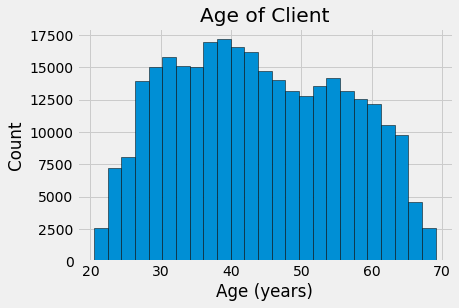

In [26]:
# let's understand this feature better

# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / -365, edgecolor = 'k', bins = 25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

In [27]:
# let's confirm this roughly
temp1 = app_train[app_train['Age'] <= 40]
temp2 = app_train[app_train['Age'] > 40]

print(f"The people less than or equal to 40 default on {round(temp1['TARGET'].mean(), 2)} % of loans")
print(f"The people above 40 default on {round(temp2['TARGET'].mean(), 2)} % of loans")
del temp1, temp2
gc.collect()

The people less than or equal to 40 default on 0.1 % of loans
The people above 40 default on 0.06 % of loans


66

Text(0.5, 1.0, 'Distribution of Ages')

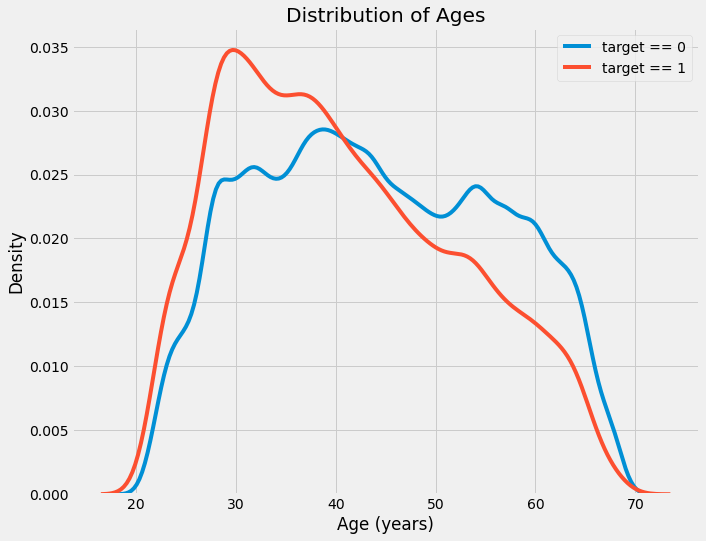

In [28]:
# let's plot a KDE plot
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] /- 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Ages')

The red curve (Target == 1, ie payment difficulties) skews towards the younger Ages. This agrees with our earlier analysis

In [29]:
# Failure to repay by Age Group Graph

age_data = app_train[['TARGET', 'Age']]

# bin the age data
age_data['Age_binned'] = pd.cut(age_data['Age'], bins=np.linspace(20, 70, num=11))
age_data.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TARGET,Age,Age_binned
0,1,26.0,"(25.0, 30.0]"
1,0,46.0,"(45.0, 50.0]"
2,0,52.0,"(50.0, 55.0]"
3,0,52.0,"(50.0, 55.0]"
4,0,55.0,"(50.0, 55.0]"
5,0,46.0,"(45.0, 50.0]"
6,0,38.0,"(35.0, 40.0]"
7,0,52.0,"(50.0, 55.0]"
8,0,55.0,"(50.0, 55.0]"
9,0,40.0,"(35.0, 40.0]"


In [30]:
age_groups = age_data.groupby('Age_binned').mean()
age_groups

,TARGET,Age
Age_binned,,
"(20.0, 25.0]",0.121086,23.609512
"(25.0, 30.0]",0.111727,28.232196
"(30.0, 35.0]",0.100854,32.969751
"(35.0, 40.0]",0.088413,38.027623
"(40.0, 45.0]",0.077393,42.940963
"(45.0, 50.0]",0.073989,47.951609
"(50.0, 55.0]",0.065655,53.062876
"(55.0, 60.0]",0.054774,57.983749
"(60.0, 65.0]",0.052917,62.873175


Again, the higher the Age, the more the TARGET tends towards 0 (no payment difficulty)

Text(0.5, 1.0, 'Failure to Repay by Age Group')

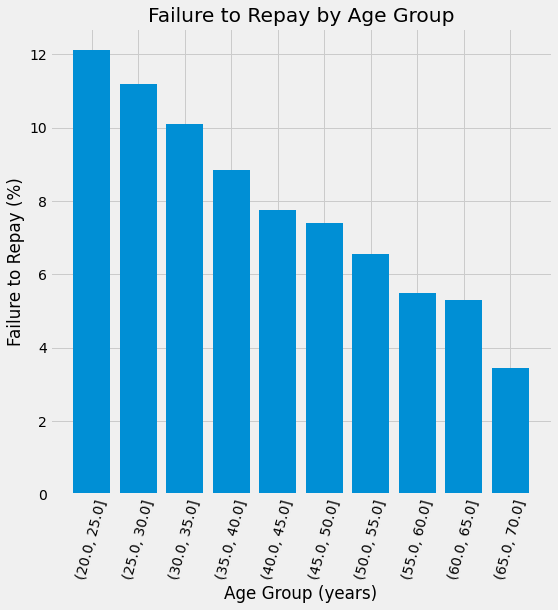

In [31]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

We also notice from the correlation matrix that the correlation from the Exteriour sources features also seemed higher than the other features. Let's investigate more on this.

In [32]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'Age']]
ext_data_corr = ext_data.corr()
ext_data_corr

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Age
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078263
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600333
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091993
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205492
Age,-0.078263,0.600333,0.091993,0.205492,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

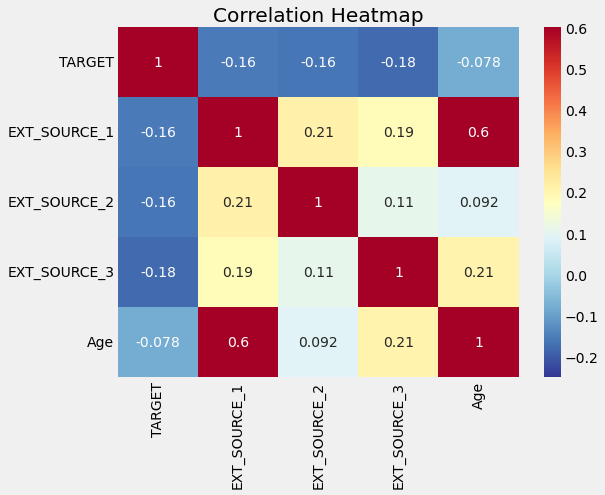

In [33]:
# let's visualize this using Seaborn's heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(ext_data_corr, cmap=plt.cm.RdYlBu_r, vmin=-0.25, vmax=0.6, annot=True)
plt.title('Correlation Heatmap')

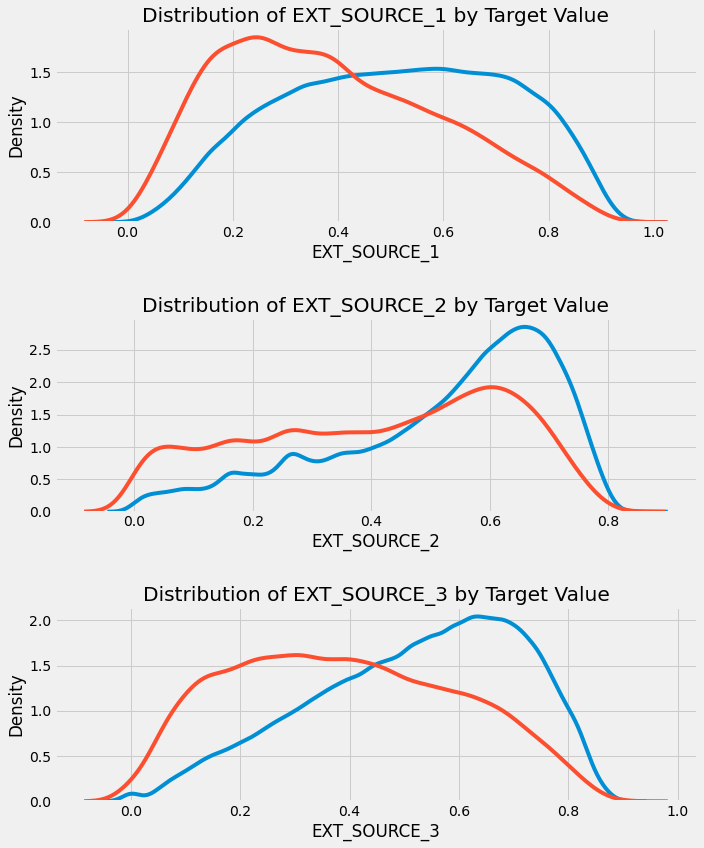

In [34]:
# visualize with KDE plot
plt.figure(figsize=(10, 12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(3, 1, i+1) # subplot for each external source
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0') # repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1') # loans that were not repaid
        
    plt.title(f"Distribution of {source} by Target Value")
    plt.xlabel(f"{source}")
    plt.ylabel("Density")
    
    
plt.tight_layout(h_pad = 2.5)

# Feature Engineering

We'll take two approaches here. 


1.   Adding Polynomial Features
2.   Adding new Features from Domain Knowledge



### Polynomial Features

In [36]:
poly_features_train = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
poly_target = poly_features_train['TARGET']
poly_features = poly_features_train.drop(columns=['TARGET'])

# handle missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
poly_features = imputer.fit_transform(poly_features.values)
poly_features_test = imputer.transform(poly_features_test.values)

In [37]:
# let's create polynomial features
from sklearn.preprocessing import PolynomialFeatures
print(f"The shape before transforming: {poly_features.shape}")
poly_transformer = PolynomialFeatures(degree=3)
poly_transformer.fit(poly_features)
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

print(f"The shape after transforming: {poly_features.shape}")

The shape before transforming: (307511, 4)
The shape after transforming: (307511, 35)


In [38]:
# for the feature names
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [39]:
# let's get a dataframe for this

poly_df = pd.DataFrame(poly_features, 
                       columns= poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_df['TARGET'] = poly_target

In [40]:
poly_df.head()

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,...,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3,TARGET
0,1.0,0.083037,0.262949,0.139376,-9461.0,0.006895,0.021834,0.011573,-785.612748,0.069142,...,0.009637,-654.152107,0.005108,-346.733022,2.353667e+07,0.002707,-183.785678,1.247560e+07,-8.468590e+11,1
1,1.0,0.311267,0.622246,0.535276,-16765.0,0.096887,0.193685,0.166614,-5218.396475,0.387190,...,0.207254,-6491.237078,0.178286,-5583.975307,1.748916e+08,0.153368,-4803.518937,1.504475e+08,-4.712058e+12,0
2,1.0,0.505998,0.555912,0.729567,-19046.0,0.256034,0.281290,0.369159,-9637.236584,0.309038,...,0.225464,-5885.942404,0.295894,-7724.580288,2.016572e+08,0.388325,-10137.567875,2.646504e+08,-6.908939e+12,0
3,1.0,0.505998,0.650442,0.535276,-19005.0,0.256034,0.329122,0.270849,-9616.490669,0.423074,...,0.226462,-8040.528832,0.186365,-6616.894625,2.349331e+08,0.153368,-5445.325225,1.933364e+08,-6.864416e+12,0
4,1.0,0.505998,0.322738,0.535276,-19932.0,0.256034,0.163305,0.270849,-10085.550751,0.104160,...,0.055754,-2076.117157,0.092471,-3443.335521,1.282190e+08,0.153368,-5710.929881,2.126570e+08,-7.918677e+12,0


In [41]:
# let's have a correlation matrix for these features
poly_corr = poly_df.corr()['TARGET'].sort_values()

# just like above, let's see the most positive and negative correlations
print(poly_corr.head(10))
print(poly_corr.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


Several of the new polynomial features have higher correlations than were in the original dataset given

In [42]:
# let's create these features for the test set as well
poly_test_df = pd.DataFrame(poly_features_test, columns= poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

# let's merge the poly_features into the train and test datasets
poly_df['SK_ID_CURR'] = app_train['SK_ID_CURR']
poly_test_df['SK_ID_CURR'] = app_test['SK_ID_CURR']

train_poly = app_train.merge(poly_df, on='SK_ID_CURR', how='left')
test_poly = app_test.merge(poly_df, on='SK_ID_CURR', how='left')

# let's align the dataframes
train_poly, test_poly = train_poly.align(test_poly, join='inner', axis=1)

print('Training data with polynomial features shape: ', train_poly.shape)
print('Testing data with polynomial features shape:  ', test_poly.shape)

Training data with polynomial features shape:  (307511, 276)
Testing data with polynomial features shape:   (48744, 276)


In [43]:
train_poly.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.018181,0.009637,-654.152107,0.005108,-346.733022,2.353667e+07,0.002707,-183.785678,1.247560e+07,-8.468590e+11
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.240927,0.207254,-6491.237078,0.178286,-5583.975307,1.748916e+08,0.153368,-4803.518937,1.504475e+08,-4.712058e+12
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.171798,0.225464,-5885.942404,0.295894,-7724.580288,2.016572e+08,0.388325,-10137.567875,2.646504e+08,-6.908939e+12
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.275185,0.226462,-8040.528832,0.186365,-6616.894625,2.349331e+08,0.153368,-5445.325225,1.933364e+08,-6.864416e+12
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.033616,0.055754,-2076.117157,0.092471,-3443.335521,1.282190e+08,0.153368,-5710.929881,2.126570e+08,-7.918677e+12


### Domain Knowledge

* CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
* ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
* CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
* DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [44]:
train_domain = app_train.copy()
test_domain = app_test.copy()

train_domain['CREDIT_INCOME_PERCENT'] = train_domain['AMT_CREDIT']/train_domain['AMT_INCOME_TOTAL']
train_domain['ANNUITY_INCOME_PERCENT'] = train_domain['AMT_ANNUITY']/train_domain['AMT_INCOME_TOTAL']
train_domain['CREDIT_TERM'] = train_domain['AMT_ANNUITY']/train_domain['AMT_CREDIT']
train_domain['DAYS_EMPLOYED_PERCENT'] = train_domain['DAYS_EMPLOYED']/train_domain['DAYS_BIRTH']

test_domain['CREDIT_INCOME_PERCENT'] = test_domain['AMT_CREDIT']/test_domain['AMT_INCOME_TOTAL']
test_domain['ANNUITY_INCOME_PERCENT'] = test_domain['AMT_ANNUITY']/test_domain['AMT_INCOME_TOTAL']
test_domain['CREDIT_TERM'] = test_domain['AMT_ANNUITY']/test_domain['AMT_CREDIT']
test_domain['DAYS_EMPLOYED_PERCENT'] = test_domain['DAYS_EMPLOYED']/test_domain['DAYS_BIRTH']

In [45]:
train_domain.shape, test_domain.shape

((307511, 246), (48744, 245))

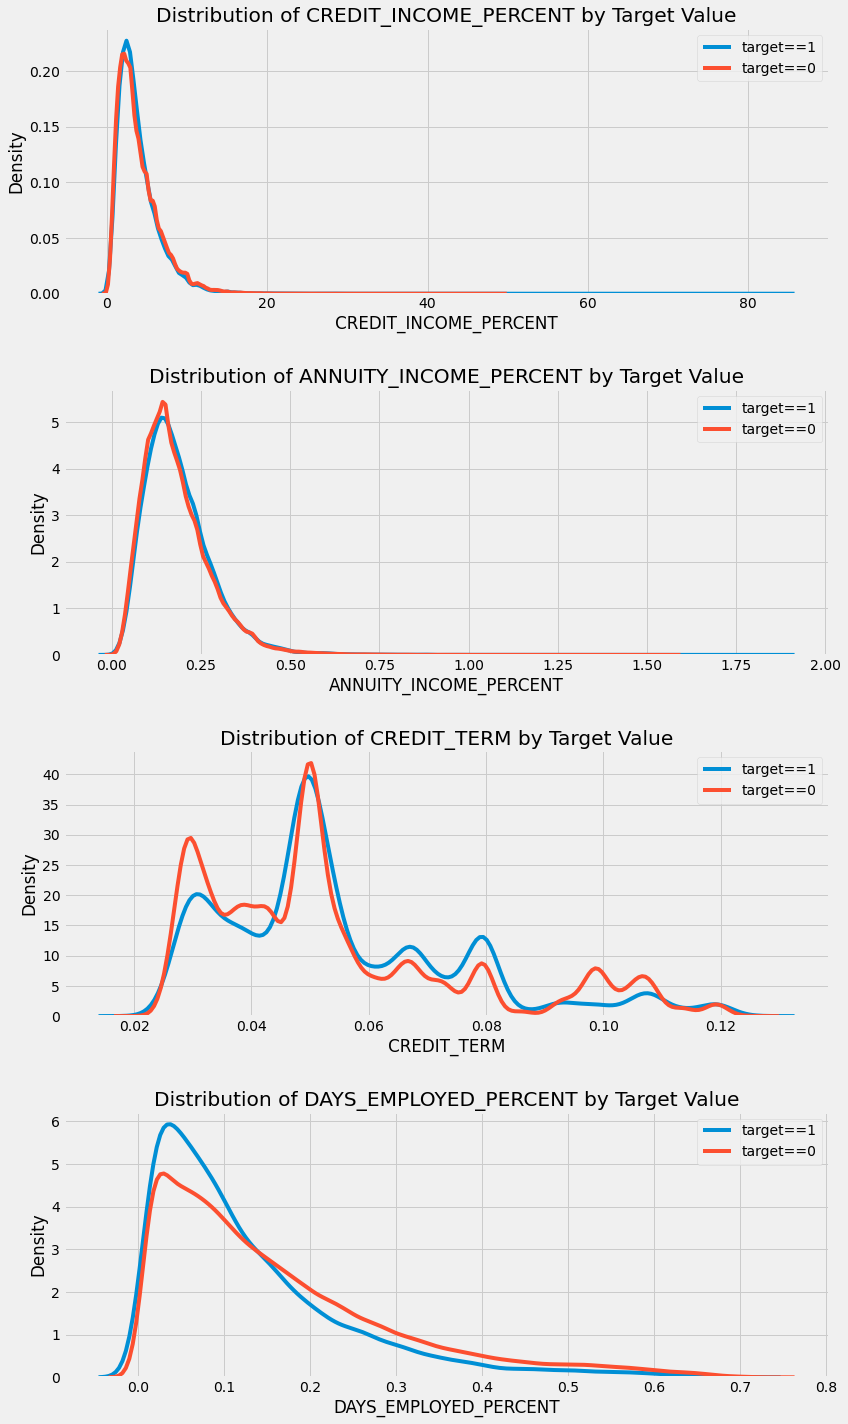

In [46]:
# let's visualize these new features

plt.figure(figsize=(12, 20))
for i, source in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    plt.subplot(4, 1, i+1)
    sns.kdeplot(train_domain.loc[train_domain['TARGET'] == 1, source], label = 'target==1') # not repaid
    sns.kdeplot(train_domain.loc[train_domain['TARGET'] == 0, source], label ='target==0') # repaid loans
    plt.title(f"Distribution of {source} by Target Value")
    plt.xlabel(f"{source}")
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout(h_pad = 2.5)

# ML Models

## Logistic Regression Baseline

In [47]:
train_labels.shape

(307511,)

In [48]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# let's drop the TARGET
if 'TARGET' in app_train:
  train = app_train.drop(columns=['TARGET'])
else:
  train = app_train.copy()

features = list(train.columns)
test = app_test.copy()

In [49]:
train.shape, test.shape

((307511, 241), (48744, 241))

In [50]:
# define the pipeline steps
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler())
])

train_transformed = pipeline.fit_transform(train)
test_transformed = pipeline.transform(test)

In [51]:
# let's use Logistic Regression as our baseline model
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=1e-4)
log_reg.fit(train_transformed, train_labels)

LogisticRegression(C=0.0001)

Now that the model has been trained, we can use it to make predictions. We want to predict the probabilities of not paying a loan, so we use the model predict.proba method. This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1). We want the probability the loan is not repaid, so we will select the second column.

The following code makes the predictions and selects the correct column.

In [52]:
predictions = log_reg.predict_proba(test_transformed)[:, 1] # predicting only the second column
predictions

array([0.06430682, 0.11618602, 0.06656332, ..., 0.06628544, 0.0722907 ,
       0.09012657])

In [53]:
# let's make it in a format for submission
submission = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': predictions})
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.064307
1,100005,0.116186
2,100013,0.066563
3,100028,0.071396
4,100038,0.118430


In [54]:
submission.to_csv('log_reg_baseline.csv', index = False)

This gave a score of 0.68496 on the Kaggle Private LB

## Random Forest Baseline

In [55]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
random_forest.fit(train_transformed, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [56]:
# let's extract feature importances from here
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

In [57]:
predictions = random_forest.predict_proba(test_transformed)[:, 1]
predictions

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.8s finished


array([0.1 , 0.1 , 0.05, ..., 0.06, 0.12, 0.26])

In [58]:
submission = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': predictions})
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.10
1,100005,0.10
2,100013,0.05
3,100028,0.06
4,100038,0.19


In [59]:
submission.to_csv('Random_forests_model.csv', index=False)

This scored 0.69541 on Kaggle. So moving on, we use the Random Forest Classifier. Let's train on the Polynomial Features and the Engineered features we created

## Polynomial Features

In [60]:
feature_names = list(train_poly.columns)

# use the Pipeline to prepare for modelling

train_poly_data = pipeline.fit_transform(train_poly)
test_poly_data = pipeline.transform(test_poly)

In [61]:
# let's fit the Random Forest model on the dataset

random_forest = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
random_forest.fit(train_poly_data, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [62]:
predictions = random_forest.predict_proba(test_poly_data)[:, 1]
submission = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': predictions})
submission.head()
submission.to_csv('Random_forests_polymodel.csv', index=False)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished


## Domain Engineered Features

In [63]:
if 'TARGET' in train_domain:
    train_domain = train_domain.drop(columns=['TARGET'])
else:
    train_domain = train_domain.copy()

# use the Pipeline to prepare for modelling

train_domain_data = pipeline.fit_transform(train_domain)
test_domain_data = pipeline.transform(test_domain)

In [64]:
# let's fit the Random Forest model on the dataset

random_forest = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
random_forest.fit(train_domain_data, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [65]:
feature_names = list(train_domain.columns)

In [66]:
# let's extract feature importances from here
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

In [67]:
submission = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': predictions})
submission.head()
submission.to_csv('Random_forests_polymodel.csv', index=False)

This performed 0.57237 on the Kaggle board

In [68]:
feature_importances

,feature,importance
0,SK_ID_CURR,0.026163
1,NAME_CONTRACT_TYPE,0.001340
2,FLAG_OWN_CAR,0.003631
3,FLAG_OWN_REALTY,0.004188
4,CNT_CHILDREN,0.006094
...,...,...
240,Age,0.019760
241,CREDIT_INCOME_PERCENT,0.025047
242,ANNUITY_INCOME_PERCENT,0.025657
243,CREDIT_TERM,0.026774


In [69]:
# let's plot the feature importances

def plot_feature_importances(df):
  """Plot importances returned by a model. This works with any measure of feature importances provided that higher is better
     Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns: shows a plot of the 15 most importance features
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
  """
  df = df.sort_values('importance', ascending=False).reset_index()
  
  # Normalize the feature importances to add up to one
  df['importance_normalized'] = df['importance'] / df['importance'].sum()

  # Make a horizontal bar chart of feature importances
  plt.figure(figsize = (10, 6))
  ax = plt.subplot()
  
  # Need to reverse the index to plot most important on top
  ax.barh(list(reversed(list(df.index[:15]))), df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
  # Set the yticks and labels
  ax.set_yticks(list(reversed(list(df.index[:15]))))
  ax.set_yticklabels(df['feature'].head(15))
    
  # Plot labeling
  plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
  plt.show()

  return df

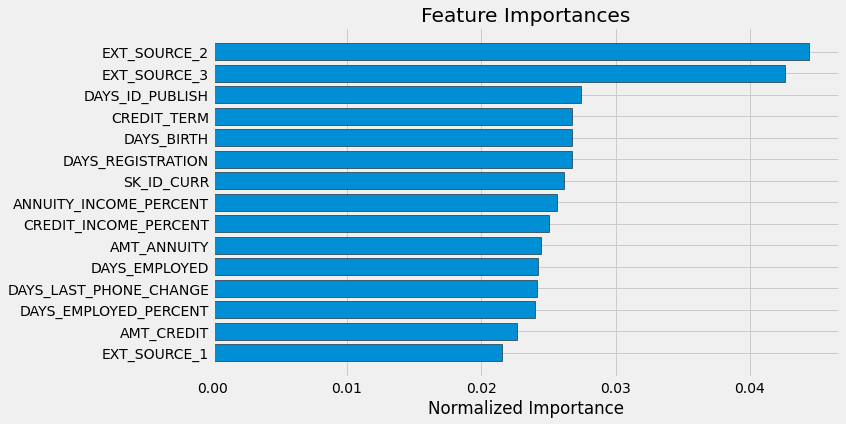

In [70]:
feature_importances_sorted = plot_feature_importances(feature_importances)

## Using SMOTE

SMOTE refers to Synthetic Minority Oversampling Technique. 

Since we have an imbalanced dataset with majority of the target being TARGET = 0 (no payment difficulty), we can use SMOTE to oversample the minority rows and downsample the majority rows

In [71]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [80]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy={0:282686, 1:100000}, random_state=42)

In [81]:
# let's create a copy of app_train and remove target

if 'TARGET' in app_train:
  train = app_train.drop(columns=['TARGET'])
else:
  train = app_train.copy()
test = app_test.copy()

In [82]:
# impute and scale
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler())
])

train_transformed = pipeline.fit_transform(train)
test_transformed = pipeline.transform(test)

In [83]:
# let's resample the train dataset
train_transformed, train_labels = smote.fit_resample(train_transformed, train_labels)

In [85]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
random_forest.fit(train_transformed, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [86]:
predictions = random_forest.predict_proba(test_transformed)[:, 1] # predicting only the second column
predictions

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.1s finished


array([0.03, 0.22, 0.09, ..., 0.06, 0.14, 0.16])

In [87]:
submission = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': predictions})
print(submission.head())
submission.to_csv('smote_model.csv', index=False)

   SK_ID_CURR  TARGET
0      100001    0.03
1      100005    0.22
2      100013    0.09
3      100028    0.08
4      100038    0.29


This scored 0.68393 on the Kaggle board. This isn't better than the Random Forest model we trained on the dataset without SMOTE. 

# What Works

1. Using RandomForestClassifier instead of LogisticRegression led us to a higher score.
2. Using PolynomialFeatures doesn't lead us to any higher score.
3. The Engineered features show up in the top feature importances so they have a role to play in the models
4. SMOTE doesn't lead us to a better score

## Future Work

In this notebook, the focus was on trying to get a baseline score to quickly get a grasp on what works and what doesn't. There are other sources of data in the dataset that we'll look into in the next notebook. These sources of data will be used for feature engineering. Also, there'll be more focus on dropping columns with too many missing entries and a deeper EDA on features from the train dataset as well. 